# Facial Landmark Detection

We will use OpenCV for landmark detection. Face landmarks are points of interest in a face like the eyes, nose bridge and the jaw outline. OpenCV provides a base class for facial landmark detection in its `face` module. The `Facemark` class is the base class for all landmark detection algorithms.

OpenCV provides 3 of these: `FacemarkKazemi`, `FacemarkAAM` and `FacemarkLBF`.

The `face` module also has methods for creating objects for the above named algorithms and also drawing landmarks. On top of that, it also has the `FaceRecognizer` class that allows us to recognize faces.

## Detection Steps

We will follow the following steps:
* We create a FaceMark object using the `FacemarkLBF` algorithm.
* We load the model using `loadModel` method.
* Lastly, we detect facial landmarks using the `fit` method.

### Loading the Model

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [5]:
facemark = cv2.face.createFacemarkLBF()
facemark.loadModel('../model/lbfmodel.yaml')

## Fitting the Model

We are now going to use the loaded model to detect facial landmarks. The `fit` method requires an image and faces in the `cv::Rect` struct> Hence, in order to fit our image, we need to detect faces in our image then pass the image, along with the detected faces to the fit algorithm. 

### Face detection

In [38]:
# detect and return a list of faces
def detectfaces(net, image, thresh_confidence = 0.70):
    # create a blob from the image
    blob = cv2.dnn.blobFromImage(image,
                                scalefactor=1.0,
                                size=(300,300),
                                mean=(104.0, 177.0, 123.0))
    
    # we set it as input to our model
    net.setInput(blob)
    detections = net.forward()

    faces = []

    h, w = image.shape[:2]

    for face in range(detections.shape[2]):
        #get confidence
        confidence = detections[0, 0, face, 2]

        if confidence >= thresh_confidence:
            x1, y1, x2, y2 = (detections[0, 0, face, 3:7] * np.array([w, h, w, h])).astype(int)
            width = x2 - x1
            height = y2 - y1
            box = np.array((x1, y1, width, height))
        else:
            continue
        
        faces.append(box)
    return np.array(faces)

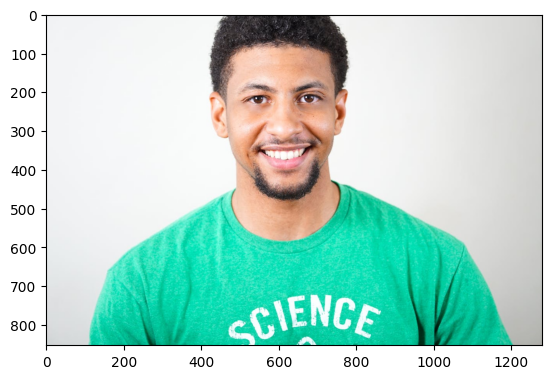

In [13]:
#loading an image
image = cv2.imread('images/smiling man.jpg')
plt.imshow(image[:, :, ::-1])

Photo by [Justin Shaifer](https://www.pexels.com/photo/photography-of-a-guy-wearing-green-shirt-1222271/).

We detect the face and draw a bounding box around it.

In [14]:
configFile = '../model/deploy.prototxt'
modelFile = '../model/res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNetFromCaffe(configFile, modelFile)

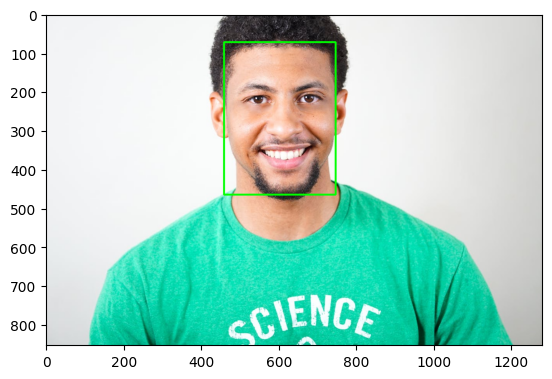

In [39]:
detected_face = detectfaces(net, image)
image_copy = image.copy()
for face in detected_face:
    cv2.rectangle(image_copy, face, (0, 255, 0), 3)
plt.imshow(image_copy[:, :, ::-1])

We can now fit our image.

In [41]:
img_landmarks = facemark.fit(image, detected_face)

The `fit` method returns image landmarks. For each face, 68 landmarks are returned. We can use the method `drawLandmarks` in the `face` module to draw the landmarks on the face.

The `fit` method returns face marks of the shape `N x 1 x 68 x 2`, with `N` the number of detected faces.

### Draw Landmarks

In [51]:
image_drawmarks = image.copy()
cv2.face.drawFacemarks(image_drawmarks, img_landmarks[1][0])
plt.imshow(image_drawmarks[:, :, ::-1])

### Multiple Images

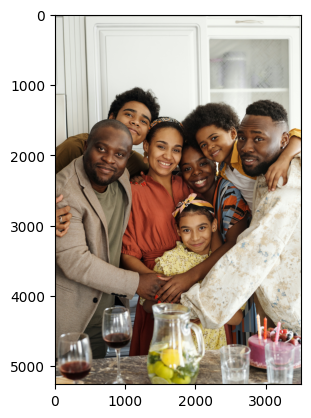

In [56]:
image2 = cv2.imread('images/sample.jpg')
plt.imshow(image2[:, :, ::-1])

In [77]:
detected_faces2 = detectfaces(net, image2)
retval, image2_landmarks = facemark.fit(image2, detected_faces2)

We can draw only landmark using the `drawFacemarks` method. The landmarks must be of a shape `1 x 68 x 2`.

In [78]:
image2_drawmarks = image2.copy()

for landmark in image2_landmarks:
    cv2.face.drawFacemarks(image2_drawmarks, landmark)

In [79]:
plt.figure(figsize=[10, 10])
plt.imshow(image2_drawmarks[:, :, ::-1])

## Polygon to connect the faces

In [106]:
image1_copy3 = image_drawmarks.copy()
#annotate image
landmarks1 = np.squeeze(img_landmarks[1][0])

for idx in range(landmarks1.shape[0]):
    cv2.putText(image1_copy3, str(idx), (landmarks1[idx]).astype(int), cv2.FONT_HERSHEY_SIMPLEX,\
                0.5, (0, 0, 255), 1, cv2.LINE_AA)

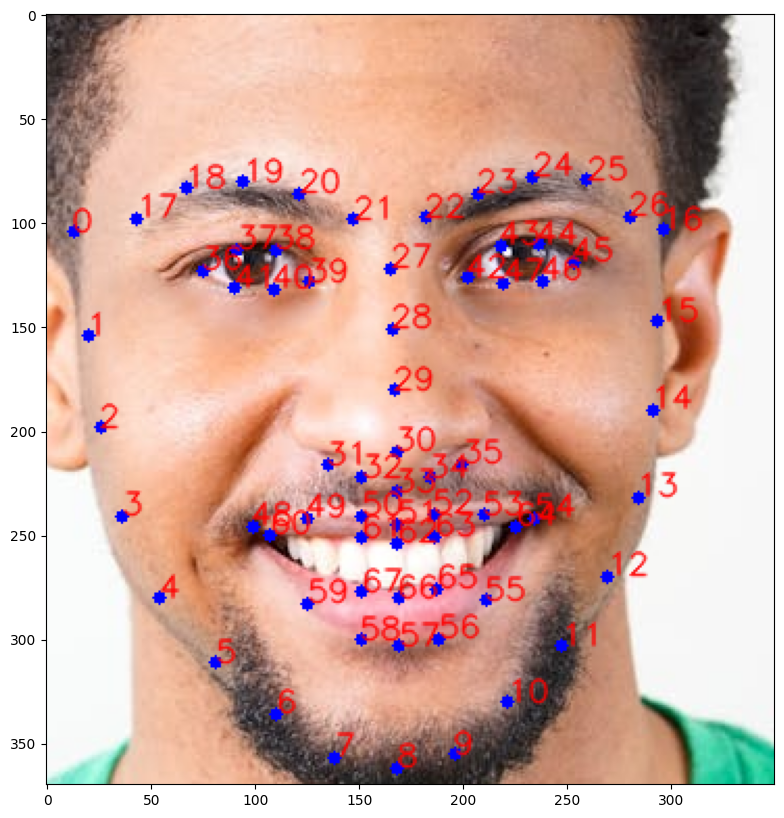

In [111]:
plt.figure(figsize=[20, 10])
plt.imshow(image1_copy3[100:470, 450:800][:, :, ::-1])

From this close up, we can infer that the eyes are indexed 36-41 and 42-47, the mouth 60 - 67(inner) and 48 - 59(outer). We can use this information to highlight the eyes.

### Highlighting Various Parts of the Face

In [143]:
image2_paint_eyes = image2.copy()

for landmark in image2_landmarks:
    color = (np.random.randint(0, 255, (3))).astype(tuple)
    # right eye
    cv2.fillConvexPoly(image2_paint_eyes, (landmark[0][36:42]).astype(int), color)
    # left eye
    cv2.fillConvexPoly(image2_paint_eyes, (landmark[0][42:48]).astype(int), color)

In [145]:
plt.figure(figsize=[15, 15])
plt.imshow(image2_paint_eyes[:, :, ::-1])